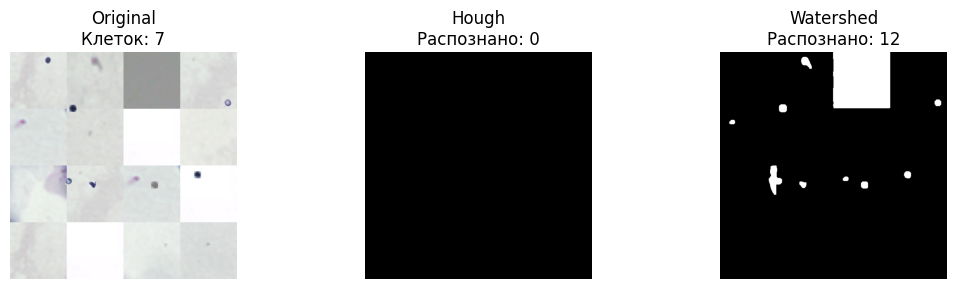

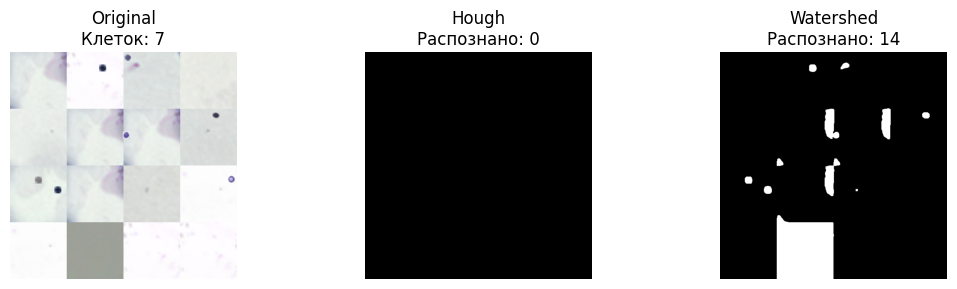

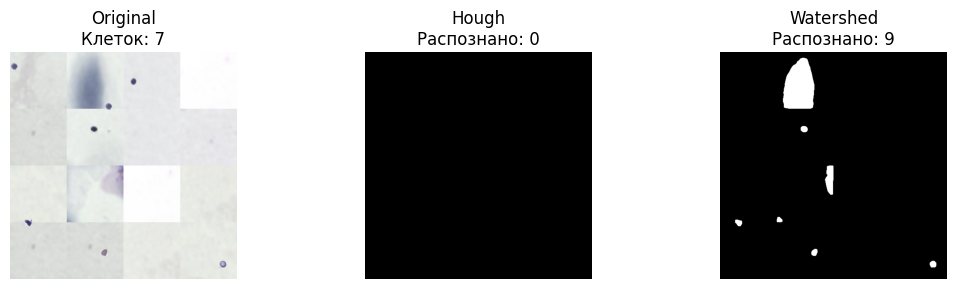

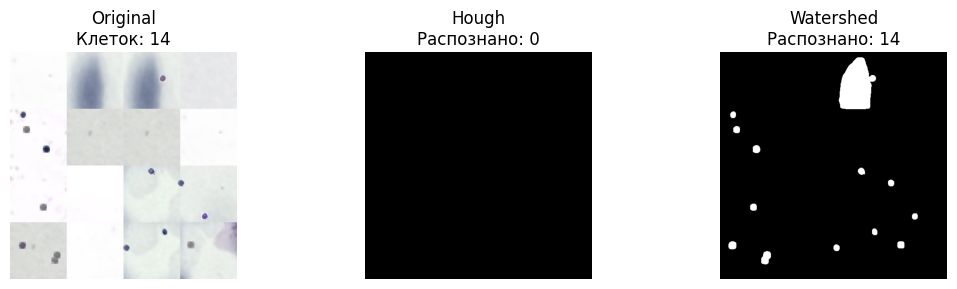

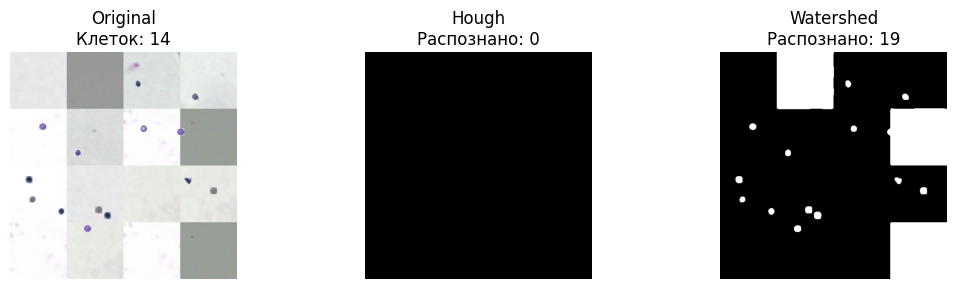

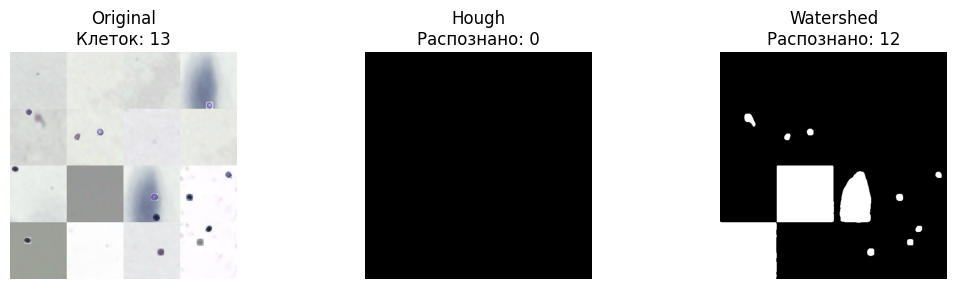

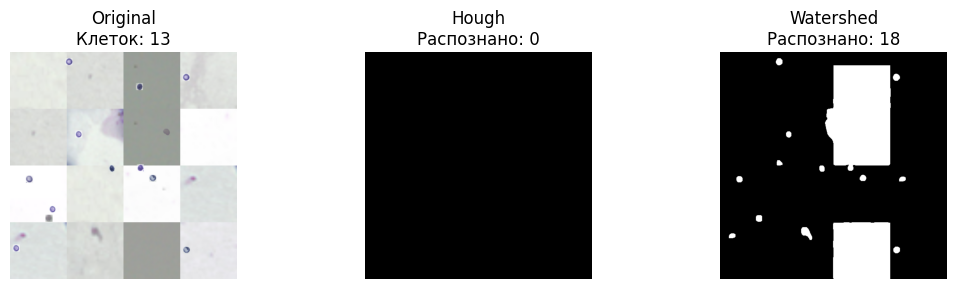

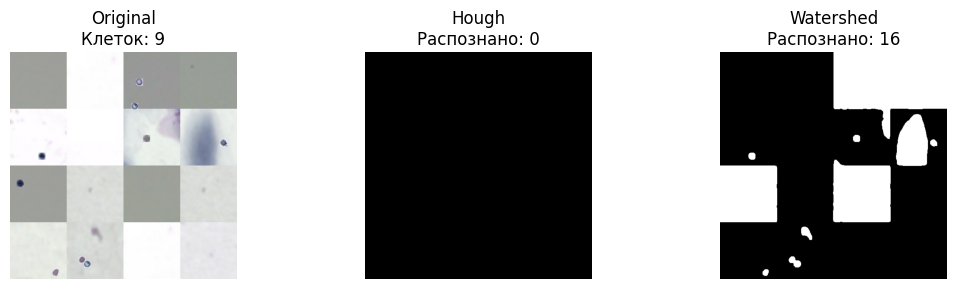

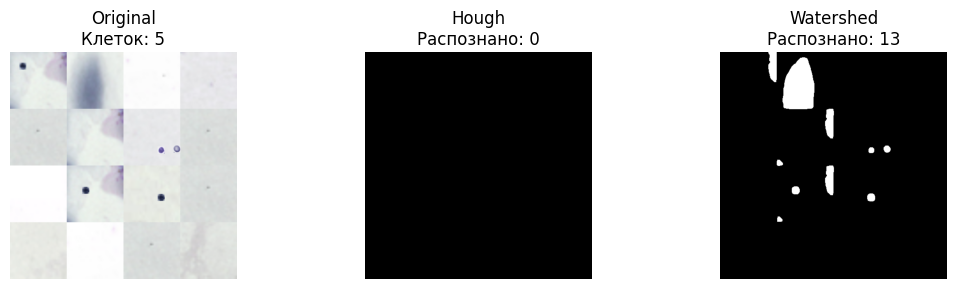

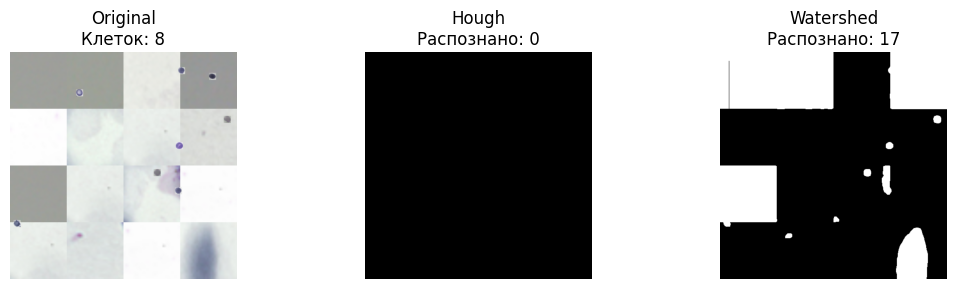

HOUGH - Accuracy: 0.99, Precision: 0.00
WATERSHED - Accuracy: 0.87, Precision: 0.07


In [1]:
import os
import random
import cv2
import numpy as np
from matplotlib import pyplot as plt
from skimage.feature import peak_local_max
from skimage.segmentation import watershed
from scipy import ndimage

def load_patches_from_folder(folder_path):
    patches = []
    for filename in os.listdir(folder_path):
        if filename.endswith((".PNG", ".jpg")):
            img = cv2.imread(os.path.join(folder_path, filename))
            if img is not None:
                patches.append(img)
    return patches

def generate_background(background_patches, num_patches=8, output_size=(512, 512)):
    background = np.zeros((output_size[0], output_size[1], 3), dtype=np.uint8)
    patch_size = 128

    for i in range(0, output_size[0], patch_size):
        for j in range(0, output_size[1], patch_size):
            patch = random.choice(background_patches)
            patch = cv2.resize(patch, (patch_size, patch_size))

            background[i:i+patch_size, j:j+patch_size] = patch

    return background

def place_cells(background, cell_patches, num_cells):
    output = background.copy()
    true_mask = np.zeros(background.shape[:2], dtype=np.uint8)
    positions = []

    for _ in range(num_cells):
        cell = random.choice(cell_patches)
        cell = cv2.resize(cell, (cell.shape[1]//2, cell.shape[0]//2))

        x = random.randint(0, background.shape[0] - cell.shape[0])
        y = random.randint(0, background.shape[1] - cell.shape[1])
        positions.append((x, y, cell.shape[0], cell.shape[1]))

        mask = np.zeros((cell.shape[0], cell.shape[1], 3), dtype=np.uint8)
        radius = min(cell.shape[0], cell.shape[1]) // 2
        center = (cell.shape[1] // 2, cell.shape[0] // 2)
        cv2.circle(mask, center, radius, (255,255,255), -1)

        mask = cv2.GaussianBlur(mask, (15, 15), 0)
        mask = mask.astype(np.float32) / 255.0

        for c in range(3):
            output[x:x+cell.shape[0], y:y+cell.shape[1], c] = (
                output[x:x+cell.shape[0], y:y+cell.shape[1], c] * (1 - mask[:, :, c]) +
                cell[:, :, c] * mask[:, :, c]
            )

        cv2.circle(true_mask, (y + cell.shape[1]//2, x + cell.shape[0]//2), radius, 1, -1)

    return output, true_mask, positions

def hough_segmentation(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.medianBlur(gray, 7)
    circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT, dp=1, minDist=20,
                              param1=50, param2=25, minRadius=10, maxRadius=50)
    pred_mask = np.zeros_like(gray)

    if circles is not None:
        circles = np.uint16(np.around(circles[0]))
        for (x, y, r) in circles:
            cv2.circle(pred_mask, (x, y), r, 1, -1)

    return pred_mask, len(circles) if circles is not None else 0

def watershed_segmentation(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (9,9), 0)
    _, binary = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    kernel = np.ones((3,3), np.uint8)
    binary = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel, iterations=2)

    distance = ndimage.distance_transform_edt(binary)
    coords = peak_local_max(distance, min_distance=20, labels=binary)

    mask = np.zeros(distance.shape, dtype=bool)
    mask[tuple(coords.T)] = True
    markers = ndimage.label(mask)[0]

    labels = watershed(-distance, markers, mask=binary)
    pred_mask = np.where(labels > 1, 1, 0).astype(np.uint8)

    return pred_mask, len(np.unique(labels))-1

def calculate_metrics(true_mask, pred_mask):
    tp = np.sum((true_mask == 1) & (pred_mask == 1))
    fp = np.sum((true_mask == 0) & (pred_mask == 1))
    fn = np.sum((true_mask == 1) & (pred_mask == 0))
    tn = np.sum((true_mask == 0) & (pred_mask == 0))

    accuracy = (tp + tn) / (tp + fp + fn + tn)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    return accuracy, precision

background_patches = load_patches_from_folder("/content/background")
cell_patches = load_patches_from_folder("/content/cells")

num_images = 10
total_metrics = {"hough": {"acc": [], "prec": []},
                 "watershed": {"acc": [], "prec": []}}

for i in range(num_images):
    background = generate_background(background_patches)
    num_cells = random.randint(5, 15)
    image, true_mask, _ = place_cells(background, cell_patches, num_cells)

    hough_mask, hough_count = hough_segmentation(image)
    ws_mask, ws_count = watershed_segmentation(image)

    h_acc, h_prec = calculate_metrics(true_mask, hough_mask)
    w_acc, w_prec = calculate_metrics(true_mask, ws_mask)

    total_metrics["hough"]["acc"].append(h_acc)
    total_metrics["hough"]["prec"].append(h_prec)
    total_metrics["watershed"]["acc"].append(w_acc)
    total_metrics["watershed"]["prec"].append(w_prec)

    fig, axes = plt.subplots(1, 3, figsize=(11,3))
    axes[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    axes[0].axis('off')
    axes[0].set_title(f"Original\nКлеток: {num_cells}")

    axes[1].imshow(hough_mask, cmap='gray')
    axes[1].axis('off')
    axes[1].set_title(f"Hough\nРаспознано: {hough_count}")

    axes[2].imshow(ws_mask, cmap='gray')
    axes[2].axis('off')
    axes[2].set_title(f"Watershed\nРаспознано: {ws_count}")

    plt.tight_layout()
    plt.show()

for method in total_metrics:
    avg_acc = np.mean(total_metrics[method]["acc"])
    avg_prec = np.mean(total_metrics[method]["prec"])
    print(f"{method.upper()} - Accuracy: {avg_acc:.2f}, Precision: {avg_prec:.2f}")